In [2]:
from SimPEG import *
from simpegem1d import *
from scipy.constants import mu_0
import numpy as np

cs = 10.
nearthick = np.logspace(-1, 1, 3)
linthick = np.ones(15)*cs
deepthick = np.logspace(1, 2, 3)
hx = np.r_[nearthick, linthick, deepthick, deepthick[-1]]
mesh1D = Mesh.TensorMesh([hx], [0.])
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC

FDsurvey = EM1DSurveyFD(
    rx_location = np.array([0., 0., 100.+30.]),
    src_location = np.array([0., 0., 100.+30.]),
    field_type = 'secondary',
    rx_type = 'Hz',
    src_type = 'VMD',
    offset = np.r_[8., 8., 8.],
    topo = np.r_[0., 0., 100.],
    depth = depth,
    frequency = np.r_[900., 7200., 56000]
)

sig_half = 1e-4
sig_blk = 1e-2
chi_half = 0.
expmap = Maps.ExpMap(mesh1D)
sig  = np.ones(FDsurvey.n_layer)*sig_half
blk_ind = (-50>LocSigZ) & (-100<LocSigZ)
sig[blk_ind] = sig_blk
m_true = np.log(sig)

prob = EM1D(
    mesh1D, sigmaMap=expmap, filter_type='key_101',
    jacSwitch=True,
    chi= np.zeros(FDsurvey.n_layer)
)
if prob.ispaired:
    prob.unpair()
if FDsurvey.ispaired:
    FDsurvey.unpair()
prob.pair(FDsurvey)     
d_true = FDsurvey.dpred(m_true)
FDsurvey.dtrue = d_true
std = 0.05
floor = 1e-16
np.random.seed(1)
uncert = std*abs(FDsurvey.dtrue)+floor
noise = std*FDsurvey.dtrue*np.random.randn(FDsurvey.dtrue.size)
FDsurvey.dobs = FDsurvey.dtrue+noise
dmisfit = DataMisfit.l2_DataMisfit(FDsurvey)
dmisfit.W = 1./(abs(FDsurvey.dobs)*std+floor)
m0 = np.log(np.ones_like(sig)*1e-3)
reg = Regularization.Tikhonov(mesh1D)
opt = Optimization.InexactGaussNewton(maxIter = 6)
opt.maxIterLS = 5
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=10**-1)
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest,target])
reg.alpha_s = 10.
reg.alpha_x = 1.
reg.alpha_y = 1.
reg.alpha_z = 1.

prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.64e-02  2.98e+03  0.00e+00  2.98e+03    2.86e+03      0              
   1  3.82e-02  7.08e+02  1.48e+02  7.14e+02    4.88e+02      0              
   2  1.91e-02  2.41e+02  1.67e+03  2.73e+02    1.91e+02      0   Skip BFGS  
   3  9.55e-03  5.71e+01  2.31e+03  7.92e+01    8.98e+01      0   Skip BFGS  
   4  4.77e-03  2.22e+01  2.48e+03  3.40e+01    8.43e+01      0   Skip BFGS  
   5  2.39e-03  6.41e+00  2.34e+03  1.20e+01    1.26e+01      0        

In [4]:
depth

array([-0.00000000e+00, -1.00000000e-01, -1.10000000e+00, -1.11000000e+01,
       -2.11000000e+01, -3.11000000e+01, -4.11000000e+01, -5.11000000e+01,
       -6.11000000e+01, -7.11000000e+01, -8.11000000e+01, -9.11000000e+01,
       -1.01100000e+02, -1.11100000e+02, -1.21100000e+02, -1.31100000e+02,
       -1.41100000e+02, -1.51100000e+02, -1.61100000e+02, -1.71100000e+02,
       -2.02722777e+02, -3.02722777e+02])

In [6]:
sig

array([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.01  ,
       0.01  , 0.01  , 0.01  , 0.01  , 0.0001, 0.0001, 0.0001, 0.0001,
       0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001])

Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda2/envs/simpeg/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['floor', 'std', 'inv', 'beta', 'pi']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


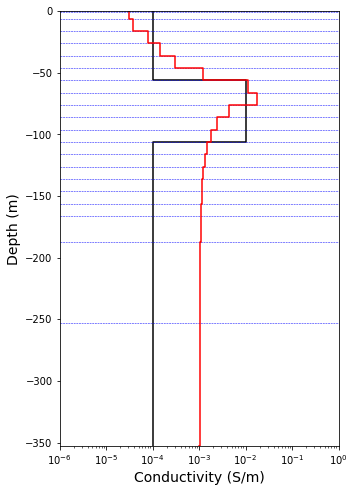

In [3]:
%pylab inline
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, LocSigZ, showlayers=False)
Utils1D.plotLayer(expmap*mopt, LocSigZ, showlayers=True,xlim=(1e-6, 1e0), **{'color':'r'})

In [5]:
# !python run_em1d.py

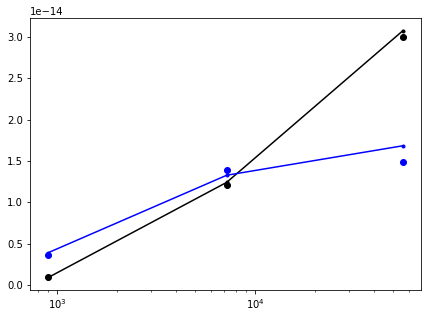

In [6]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(FDsurvey.frequency, -d_true[0:FDsurvey.Nfreq], 'k.-')
axes.plot(FDsurvey.frequency, -d_true[FDsurvey.Nfreq:], 'b.-')
axes.plot(FDsurvey.frequency, -FDsurvey.dobs[0:FDsurvey.Nfreq], 'ko')
axes.plot(FDsurvey.frequency, -FDsurvey.dobs[FDsurvey.Nfreq:], 'bo')
# axes.plot(FDsurvey.frequency, uncert[0:FDsurvey.Nfreq], 'k*')
# axes.plot(FDsurvey.frequency, uncert[FDsurvey.Nfreq:], 'r*')
axes.set_xscale('log')

In [7]:
from scipy.linalg.blas import cgemm
import numpy as np

In [8]:
a = np.ones((22, 101), dtype=complex)
x = np.ones(101, dtype=complex)
alpha = complex(1.)
# cgemv(a, x, )

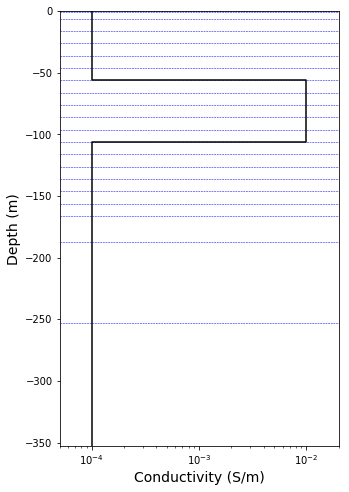

In [9]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, LocSigZ, showlayers=True)

In [10]:
opt.counter.summary()
xc = opt.recall('xc')

Counters:
  InexactGaussNewton.doEndIteration       :        6
  InexactGaussNewton.doStartIteration     :        7
  InexactGaussNewton.scaleSearchDirection :        6

Times:                                        mean      sum
  EM1D.Jtvec_approx                       : 4.10e-04, 5.33e-03,   13x
  EM1D.Jvec_approx                        : 4.37e-04, 5.68e-03,   13x
  InexactGaussNewton.findSearchDirection  : 6.51e-03, 3.90e-02,    6x
  InexactGaussNewton.minimize             : 8.35e-01, 8.35e-01,    1x
  InexactGaussNewton.modifySearchDirection: 9.06e-02, 5.44e-01,    6x
  InexactGaussNewton.projection           : 8.82e-05, 2.82e-03,   32x


In [11]:
dpredall = []
for i in range(len(xc)):
    dpredtemp = FDsurvey.dpred(xc[i])
    dpredall.append(dpredtemp)


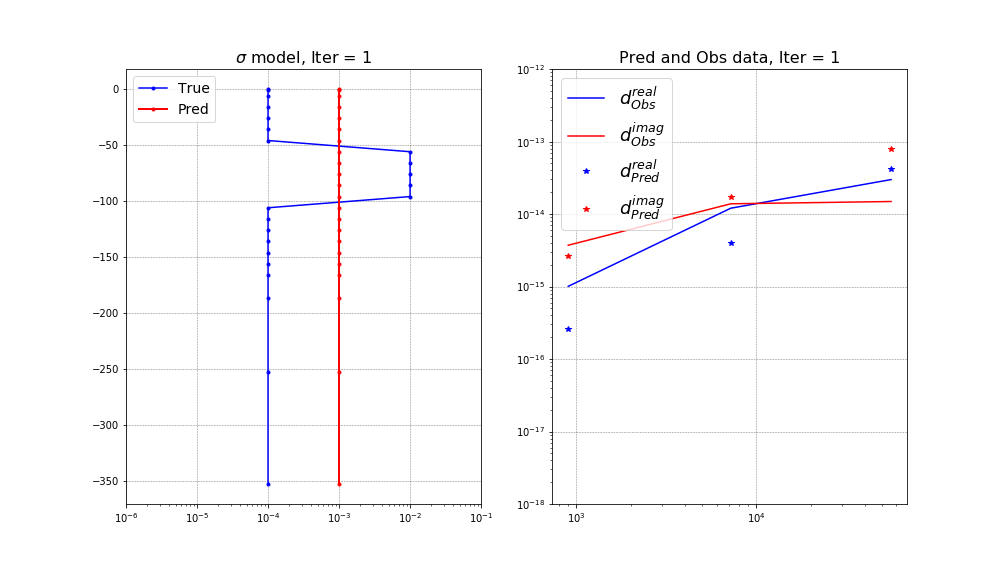
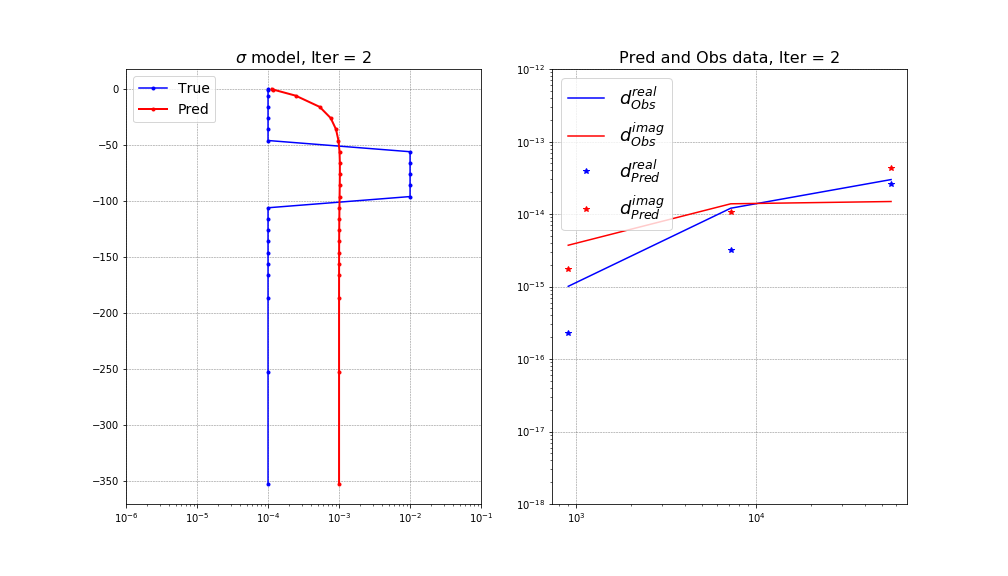
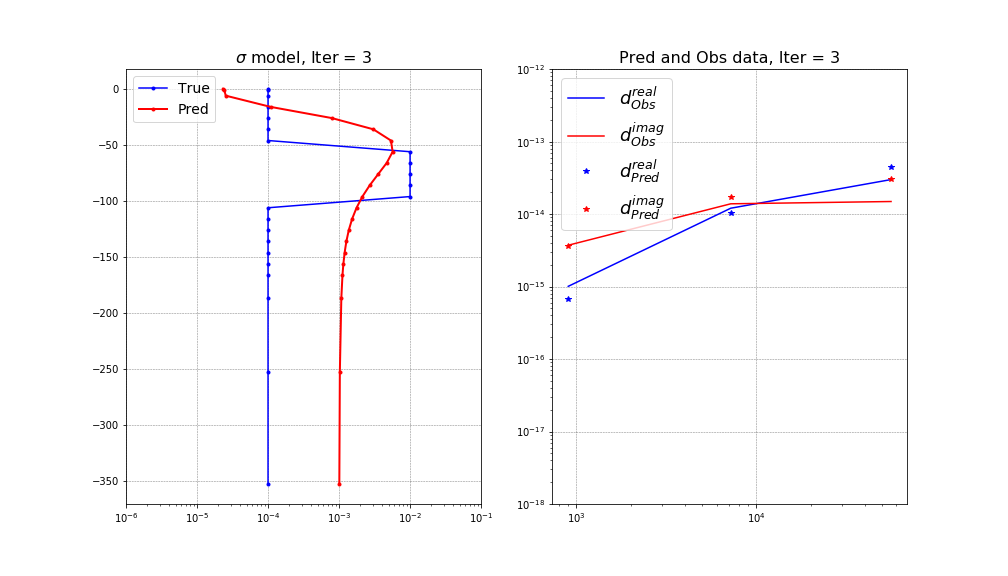
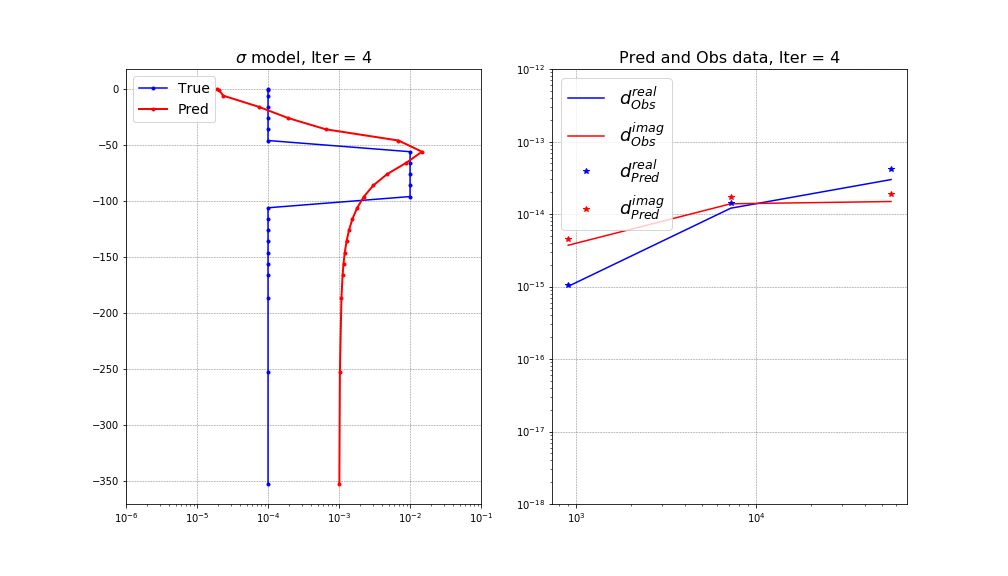
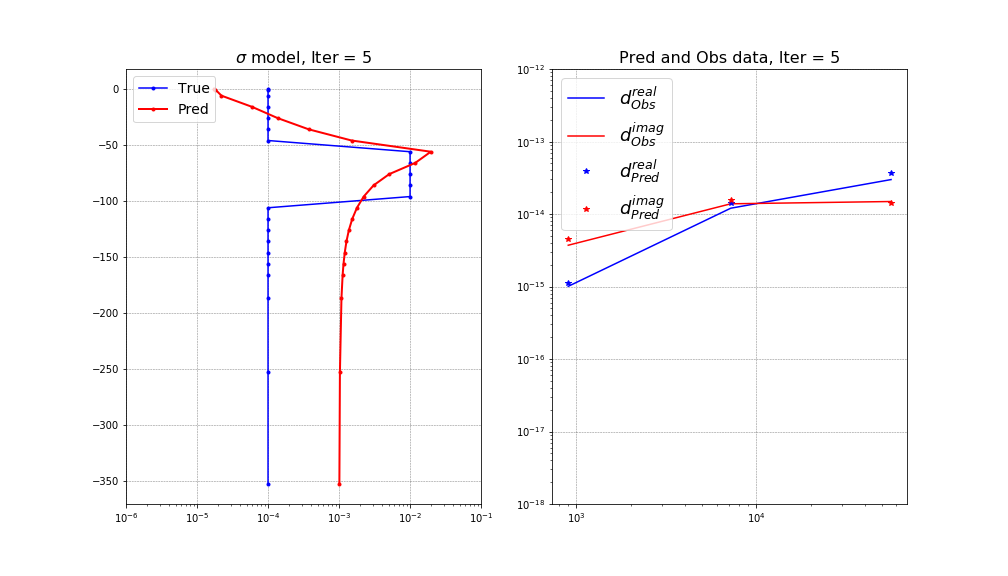
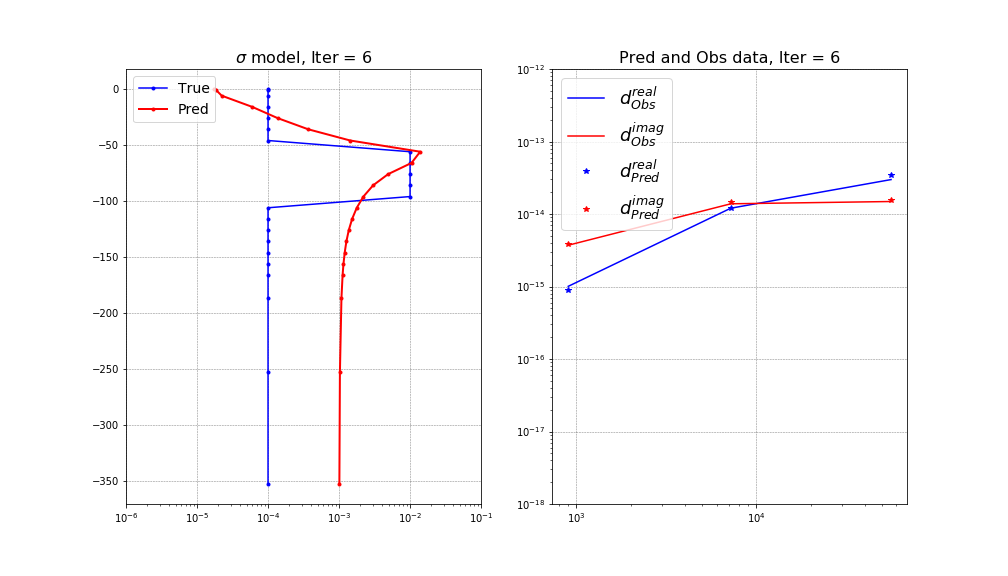

In [12]:
from JSAnimation import IPython_display
from matplotlib import animation

fig, ax = subplots(1,2, figsize=(14, 8))
ax[0].plot(sig, LocSigZ,  'b.-')
ax[0].grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.5)
ax[1].grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.5)
ax[1].plot(FDsurvey.frequency, abs(FDsurvey.dobs[0:FDsurvey.Nfreq]), 'b-')
ax[1].plot(FDsurvey.frequency, abs(FDsurvey.dobs[FDsurvey.Nfreq:]), 'r-')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[0].set_xlim(1e-6, 1e-1)
ax[1].set_ylim(1e-18, 1e-12)

frame1, = ax[0].plot([], [],  'r.-', lw=2)
frame2, = ax[1].plot([], [],  'b*' , lw=2)
frame3, = ax[1].plot([], [],  'r*' , lw=2)

def animate(i_id):
#     
    frame1.set_data(expmap*xc[i_id], LocSigZ)
    frame2.set_data(FDsurvey.frequency, abs(dpredall[i_id][:FDsurvey.Nfreq]))
    frame3.set_data(FDsurvey.frequency, abs(dpredall[i_id][FDsurvey.Nfreq:]))
    
    ax[0].legend(('True', 'Pred'), loc=2, fontsize = 14)
    ax[1].legend(('$d^{real}_{Obs}$', '$d^{imag}_{Obs}$', '$d^{real}_{Pred}$', '$d^{imag}_{Pred}$'), loc=2, fontsize = 18)
    ax[0].set_title('$\sigma$ model, Iter = ' + str(i_id+1), fontsize = 16)
    ax[1].set_title('Pred and Obs data, Iter = ' + str(i_id+1), fontsize = 16)
    return frame1, frame2, frame3

animation.FuncAnimation(fig, animate, frames=len(xc), interval=40, blit=True)

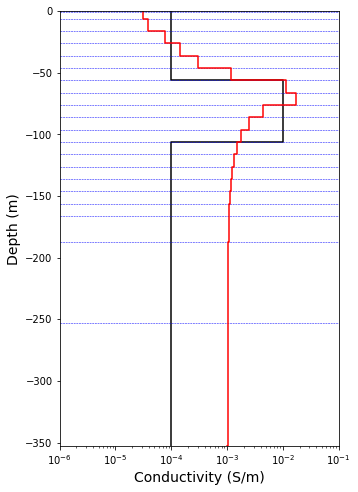

In [13]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, LocSigZ, showlayers=False)
Utils1D.plotLayer(expmap*mopt, LocSigZ, showlayers=True,xlim=(1e-6, 1e-1), **{'color':'r'})